# 지도학습 - 다중선형회귀

In [1]:
from hossam import *

from pandas import DataFrame, read_excel
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np
from itertools import combinations

from scipy.stats import pearsonr, spearmanr
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

c:\Users\wodyd\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


📦 아이티윌 이광호 강사가 제작한 라이브러리를 사용중입니다.
📚 자세한 사용 방법은 https://py.hossam.kr 을 참고하세요.
📧 Email: leekh4232@gmail.com
🎬 Youtube: https://www.youtube.com/@hossam-codingclub
📝 Blog: https://blog.hossam.kr/
🔖 Version: 0.4.18

✅ 시각화를 위한 한글 글꼴(NotoSansKR-Regular)이 자동 적용되었습니다.


In [2]:
origin = load_data('fish')
print(f"데이터셋 크기: {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")
print(origin.info())
origin.head()

농어의 길이,높이,두께,무게를 조사한 데이터 셋
데이터셋 크기: (56, 4)
열 개수: 4
행 개수: 56
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   길이      56 non-null     float64
 1   높이      56 non-null     float64
 2   두께      56 non-null     float64
 3   무게      56 non-null     float64
dtypes: float64(4)
memory usage: 1.9 KB
None


,길이,높이,두께,무게
0,8.4,2.11,1.41,5.9
1,13.7,3.53,2.00,32.0
2,15.0,3.82,2.43,40.0
3,16.2,4.59,2.63,51.5
4,17.4,4.59,2.94,70.0


## 1. 데이터 확인 및 전처리
### 1. 데이터 품질 검사

In [3]:
# 원본 데이터 프레임 참조
# -> 이후 코드를 고정으로 사용하기 위해 객체 이름을 df로 통일하는 용도
df = origin

# 기초통계량
desc = df.describe().T

# 결측치 확인
desc['missing'] = df.isnull().sum()

# IQR, 이상치 경계, 이상치 수, 이상치 비율
# IQR, 이상치 경계, 이상치 수, 이상치 비율
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outlier_count = ((df < lower_bound) | (df > upper_bound)).sum()
outlier_ratio = outlier_count / len(df) * 100
desc['outlier_count'] = outlier_count
desc['outlier_ratio(%)'] = outlier_ratio

# 숫차형 컬럼 이름만 추출
num_cols = df.select_dtypes(include = np.number).columns

# 왜도, 로그 변환 필요성 확인
for column in df.columns:
    skewness = df[column].skew()
    if abs(skewness) < 0.5:
        strength = 'week'
        log_transform = 'not needed'
    elif abs(skewness) < 1:
        strength = 'normal'
        log_transform = 'recommended'
    else:
        strength = 'strong'
        log_transform = 'needed'

    desc.loc[column, 'skewness'] = skewness
    desc.loc[column, 'skewness_strength'] = strength
    desc.loc[column, 'log_transform'] = log_transform

desc

,count,mean,std,min,25%,50%,75%,max,missing,outlier_count,outlier_ratio(%),skewness,skewness_strength,log_transform
길이,56.0,27.892857,9.021668,8.40,21.825,25.300,36.625,44.00,0,0,0.0,0.270547,week,not needed
높이,56.0,7.862143,2.878343,2.11,5.690,6.920,10.850,12.80,0,0,0.0,0.361355,week,not needed
두께,56.0,4.745536,1.775006,1.41,3.520,4.155,6.450,8.14,0,0,0.0,0.424951,week,not needed
무게,56.0,382.239286,347.617717,5.90,120.000,207.500,692.500,1100.00,0,0,0.0,0.844368,normal,recommended


### 2. 로그 변환

In [4]:
# 무게 컬럼에 대해서만 처리
df1 = origin.copy()
df1['무게'] = np.log1p(df1['무게'])
df1.head()

,길이,높이,두께,무게
0,8.4,2.11,1.41,1.931521
1,13.7,3.53,2.00,3.496508
2,15.0,3.82,2.43,3.713572
3,16.2,4.59,2.63,3.960813
4,17.4,4.59,2.94,4.262680


### 3. 상자그림 확인

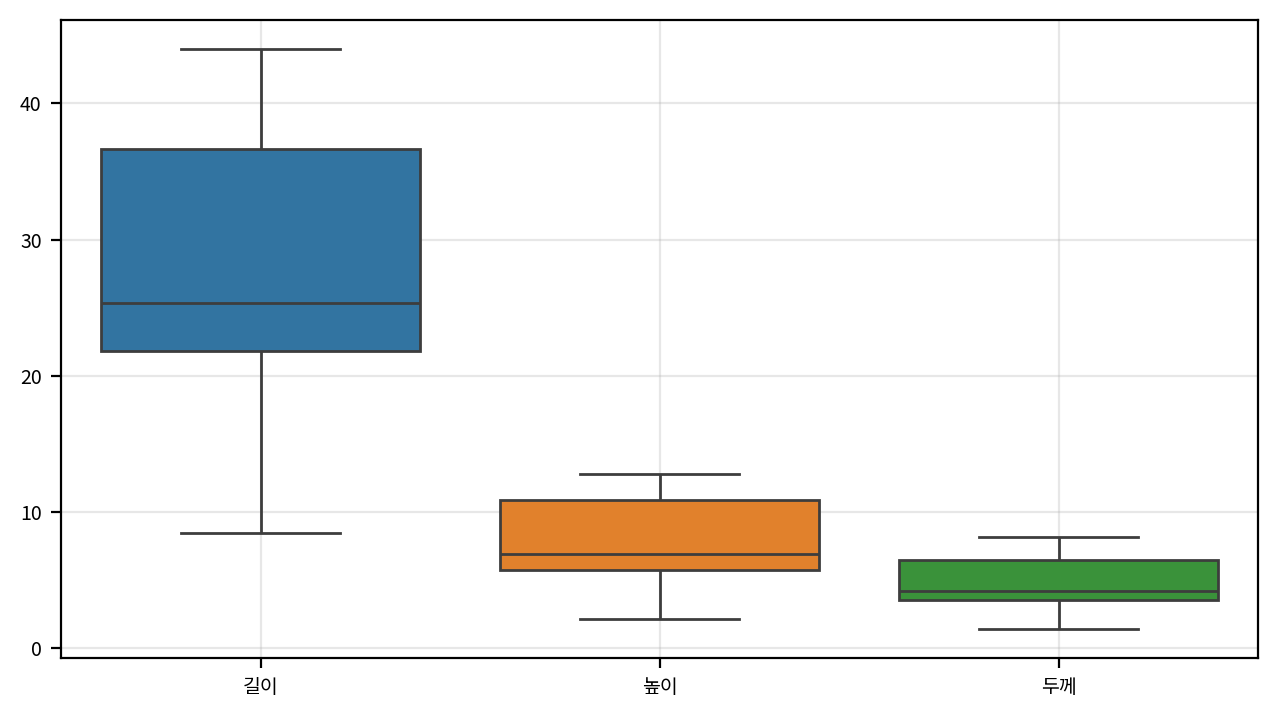

In [5]:
figsize = (1280/my_dpi, 720/my_dpi)
fig, ax = plt.subplots(1, 1, figsize = figsize, dpi = my_dpi)

sb.boxplot(data = df1[['길이','높이','두께']])
ax.grid(True, alpha = 0.3)

plt.tight_layout()
plt.show()
plt.close()

#### 인사이트

- 데이터간의 차이가 크기 떄문에 스케일링이 필요

### 4. 데이터 스케일링

- 스케일링은 독립변수만!

In [6]:
df = df1[['길이','높이','두께']]
scaler = StandardScaler()
df2 = DataFrame(scaler.fit_transform(df), columns = df.columns)
df2['무게'] = df1['무게']
df2.head()

,길이,높이,두께,무게
0,-2.180225,-2.016507,-1.896175,1.931521
1,-1.587434,-1.518703,-1.560774,3.496508
2,-1.442032,-1.417039,-1.316328,3.713572
3,-1.307815,-1.147103,-1.202633,3.960813
4,-1.173599,-1.147103,-1.026405,4.262680


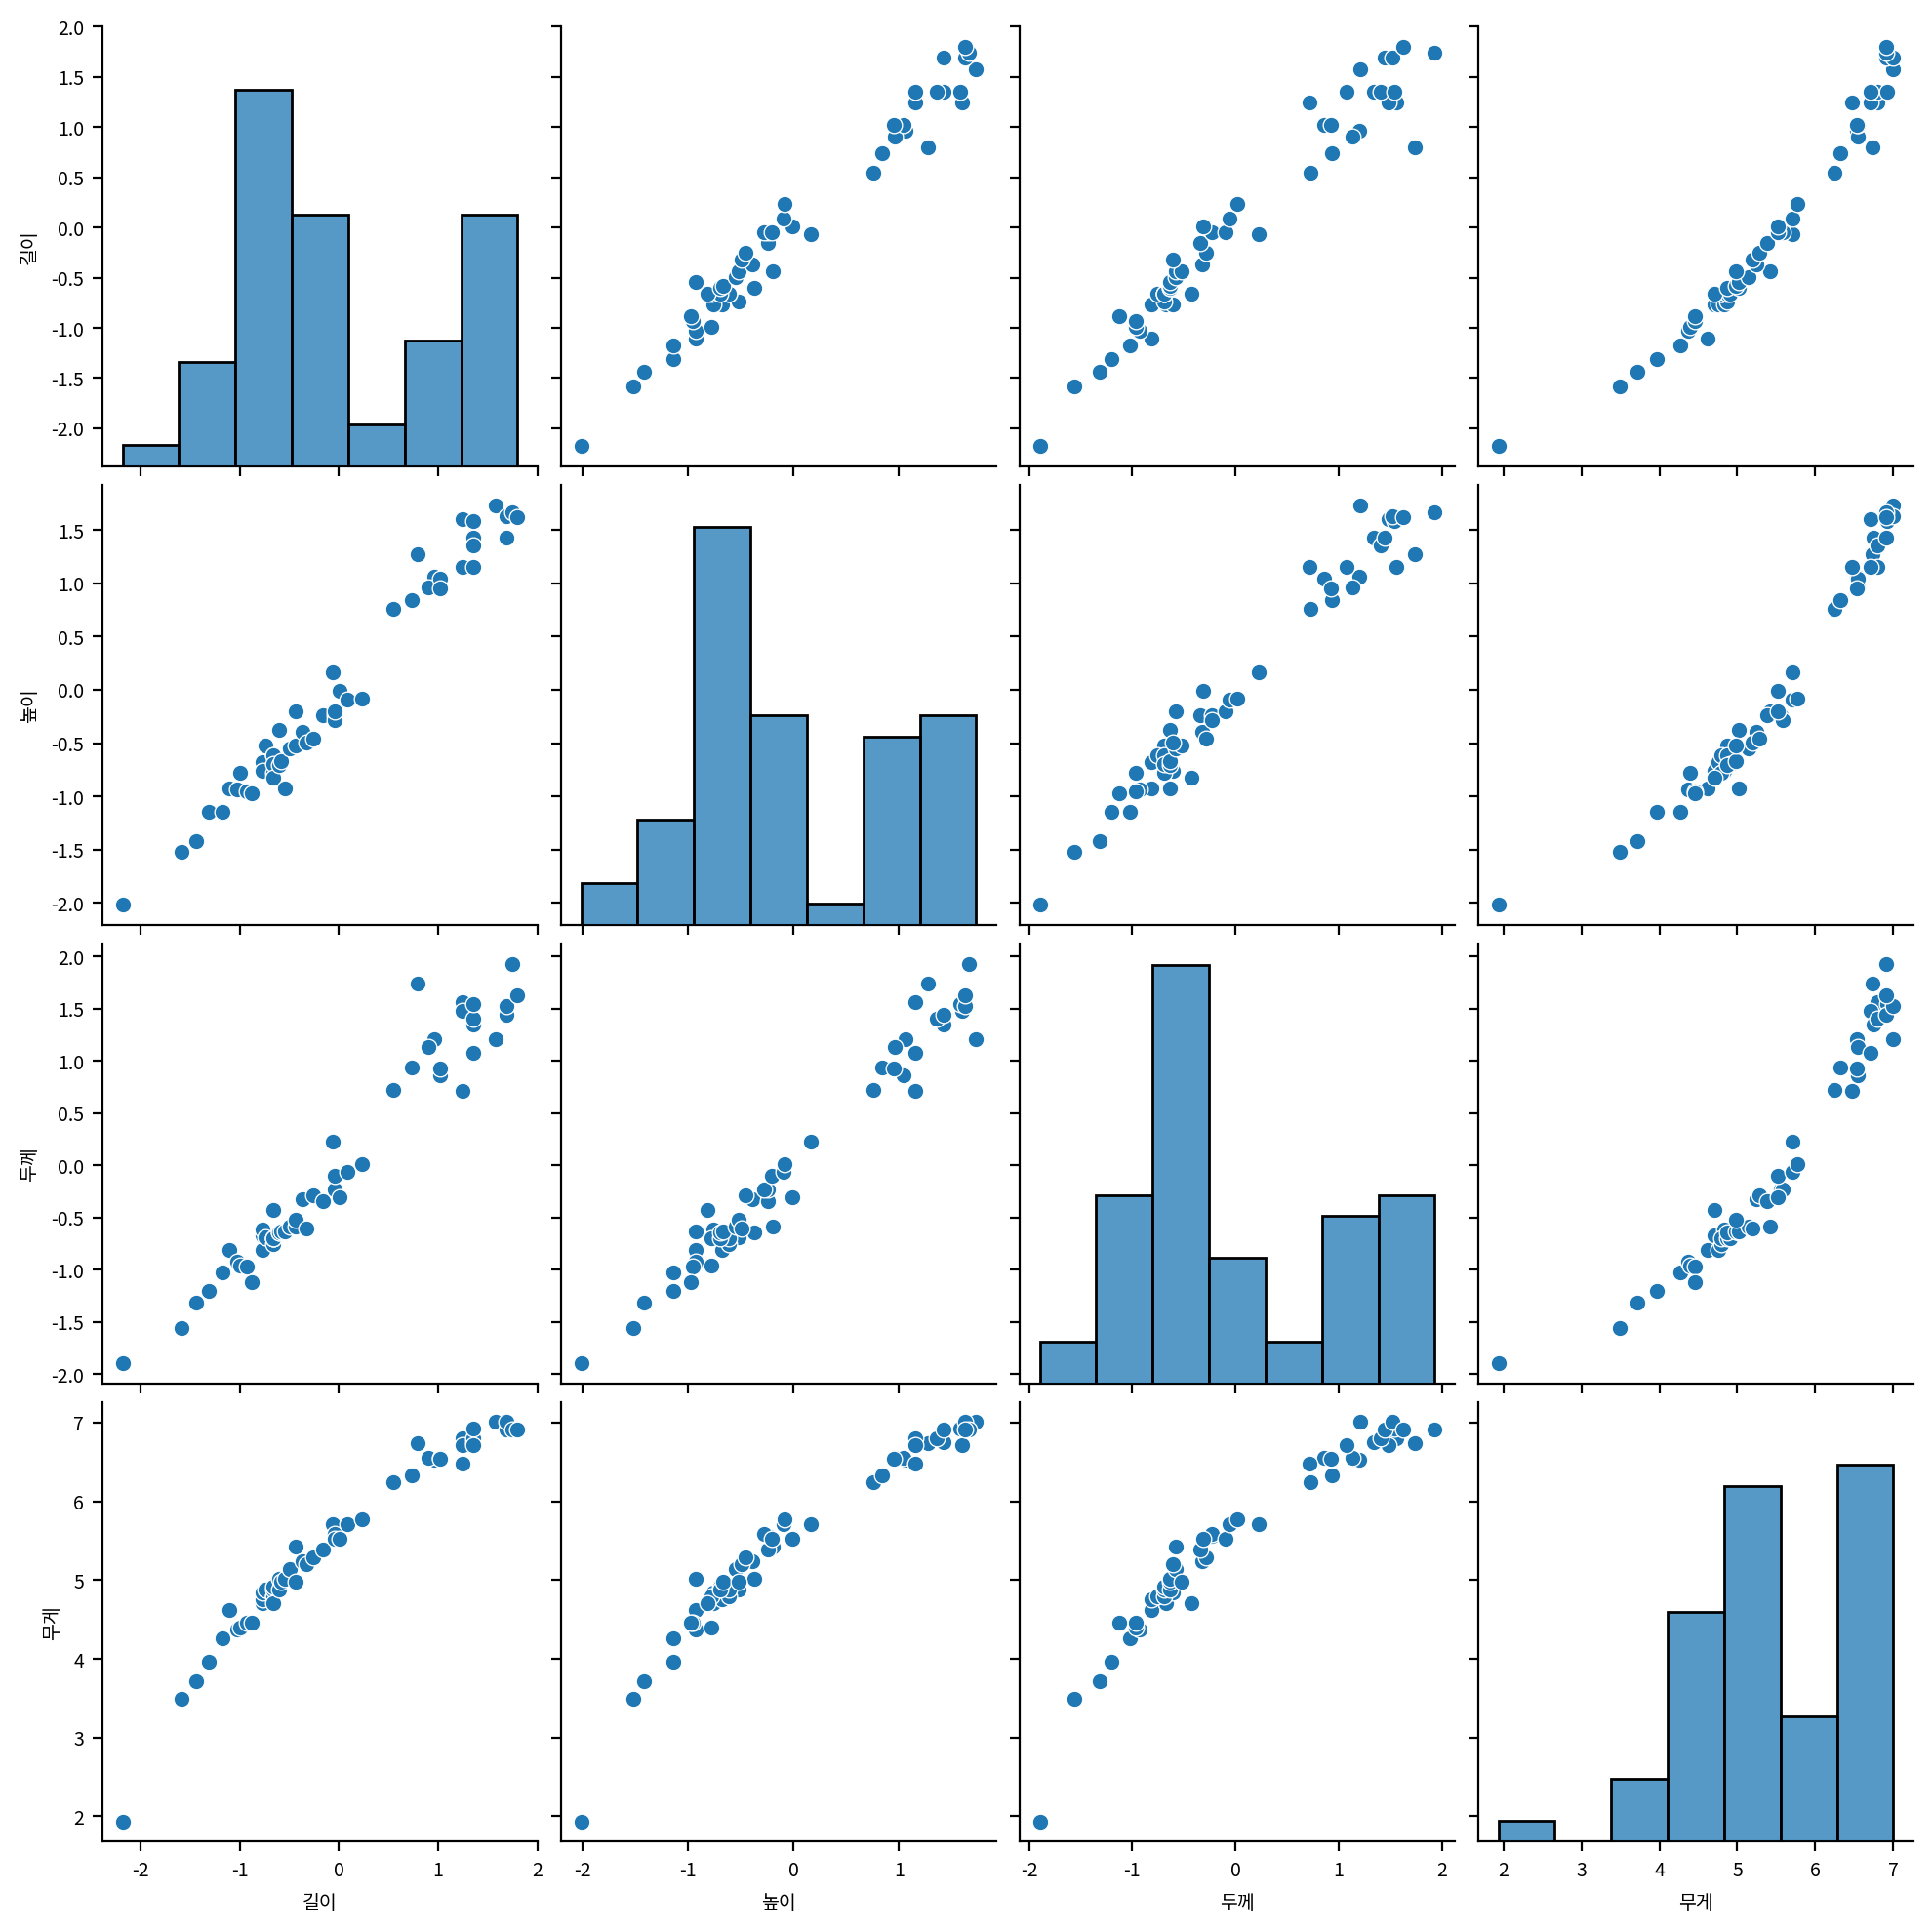

In [7]:
sb.pairplot(df2)
plt.show()
plt.close()

#### 인사이트

- 모든 변수가 종속변수인 두께에 상관관계가 있는 것으로 보인다.
    - 좀 더 확실판 판정을 위해 상관분석 필요

- 무게의 경우 선형성 가정을 충족하지 않는 것 같지만 예제 데이터이므로 선형성 가정을 충족한다고 가정하고 진행

## 3. 추론 통계
### 1. 상관분석

In [8]:
# 원본 데이터 프레임 참조
# -> 이후 코드를 고정으로 사용하기 위해 객체 이름을 df로 통일하는 용도

data = df2

# 이상치 판단 기준 절대값
z_thresh = 3.0

# 상관분석을 위한 최소 표본 수
min_n = 8

# 유의수준 판단 기준값
alpha = 0.05

# 숫자형 컬럼이름 추출
cols = data.select_dtypes(include = [np.number]).columns.tolist()

# z-score 기반 이상치 유무 계산
z_outlier_flags ={}
for c in cols:
    col = data[c].dropna()
    if col.std(ddof=1) ==0:
        z_outlier_flags[c] = False
        continue
    z = (col - col.mean()) / col.std(ddof = 1)
    z_outlier_flags[c] = (z.abs() > z_thresh).any()

rows = []

for a,b in combinations(cols, 2):
    # 공통 관측치 사용
    pair_df = data[[a,b]].dropna()
    if len(pair_df) < max(3, min_n):
        # 표본이 너무 적으면 계산하지 않음
        rows.append(
            {
                'var_a': a,
                'var_b': b,
                'n': len(pair_df),
                'linearity': False,
                'outlier_flag': True,
                'chosen': None,
                'corr': np.nan,
                'pval': np.nan,
                'significant': False,
                'strength': 'no correlation'
            }
        )
        continue

    x = pair_df[a]
    y = pair_df[b]

    # 상수열/분산 체크 -> 상관계수 게산 불가
    if x.nunique(dropna = True) <= 1 or y.nunique(dropna = True) <=1:
        rows.append(
            {
                'var_a': a,
                'var_b': b,
                'n': len(pair_df),
                'linearity': False,
                'outlier_flag': True,
                'chosen': None,
                'corr': np.nan,
                'pval': np.nan,
                'significant': False,
                'strength': 'no correlation'}
        )
        continue

    # 선형성: Ramsey RESET(지정 차수 전부 p>alpha 여야 통과)
    linearity_ok = False
    try:
        X_const = sm.add_constant(x)
        model = sm.OLS(y, X_const).fit()
        pvals = []
        for pwr in linearity_power:
            reset = linear_reset(model, power=pwr, use_f = True)
            pvals.append(reset.pvalue)
            # 모든 차수에서 유의하지 않을 때 선형성 충족으로 간주
            if len(pvals) > 0:
                linearity_ok = all([pv > alpha for pv in pvals])
    except Exception:
        linearity_ok = False

    # 이상치 플래그(두 변수 중 하나라도 z-outlier 있으면 True)
    outlier_flag = bool(z_outlier_flags.get(a, False) or z_outlier_flags.get(b, False))

    # 상관 계산: 선형-무이상치면 pearson, 아니면 spearman
    try:
        if linearity_ok and not outlier_flag:
            chosen = 'pearson'
            corr_val, pval = pearsonr(x, y)
        else:
            chosen = 'spearman'
            corr_val, pval = spearmanr(x, y)
    except Exception:
        chosen = None
        corr_val, pval = np.nan, np.nan

    # 유의성, 강도
    significant = False if np.isnan(pval) else pval <= alpha
    abs_r = abs(corr_val) if not np.isnan(corr_val) else 0 
    if abs_r > 0.7:
        strength = 'strong'
    elif abs_r > 0.3:
        strength = 'medium'
    elif abs_r > 0:
        strength = 'weak'
    else:
        strength = 'no coreelation'

    rows.append(
        {
            'var_a': a,
                'var_b': b,
                'n': len(pair_df),
                'linearity': linearity_ok,
                'outlier_flag': outlier_flag,
                'chosen': chosen,
                'corr': corr_val,
                'pval': pval,
                'significant': significant,
                'strength': strength
                }
    )

result_df = DataFrame(rows)
result_df

,var_a,var_b,n,linearity,outlier_flag,chosen,corr,pval,significant,strength
0,길이,높이,56,False,False,spearman,0.970562,4.577162e-35,True,strong
1,길이,두께,56,False,False,spearman,0.966186,1.826845e-33,True,strong
2,길이,무게,56,False,True,spearman,0.986639,3.061102e-44,True,strong
3,높이,두께,56,False,False,spearman,0.954701,4.233630e-30,True,strong
4,높이,무게,56,False,True,spearman,0.978868,6.598050e-39,True,strong
5,두께,무게,56,False,True,spearman,0.971928,1.291124e-35,True,strong


#### 인사이트

- 종속변수인 무게에 길이, 높이, 두께가 모두 높은 상관성을 갖는 것으로 보인다.

- 하지만 독립변수간(길이-높이, 높이-두께, 두께-길이)에도 상관성이 있는 것으로 확인된다. 이와 같은 경우를 자기상관이 있다고 하는데, 이 경우 회귀분석을 수행하면 다중공선성 문제가 발생하여 모델의 신뢰성이 떨어진다.

- 정확한 분석을 위해서는 독립변수간 VIF를 확인하고 다중공선성 문제를 해결해야 하지만 예제 데이터이므로 여기서는 다중공선성을 무시하고 진행하도록 한다.

In [9]:
df2.to_excel('fish_processed.xlsx', index = False)

In [10]:
df3 = read_excel('fish_processed.xlsx')
display(df3.info())
df3.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   길이      56 non-null     float64
 1   높이      56 non-null     float64
 2   두께      56 non-null     float64
 3   무게      56 non-null     float64
dtypes: float64(4)
memory usage: 1.9 KB


None

,길이,높이,두께,무게
0,-2.180225,-2.016507,-1.896175,1.931521
1,-1.587434,-1.518703,-1.560774,3.496508
2,-1.442032,-1.417039,-1.316328,3.713572
3,-1.307815,-1.147103,-1.202633,3.960813
4,-1.173599,-1.147103,-1.026405,4.262680


### 1. 데이터 분리

In [11]:
yname = '무게'
x = df3.drop(columns =[yname])
y = df3[[yname]]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((39, 3), (17, 3), (39, 1), (17, 1))

### 2. 선형회귀 분석

- 성능평가는 검증 데이터에 대해서만 수행

In [12]:
# 분석모델 생성
estimator = LinearRegression(n_jobs = -1)
estimator.fit(x_train, y_train)
estimator

print('계수(기울기):', estimator.coef_)
print('절편:', estimator.intercept_)
print('훈련 데이터 설명력:', estimator.score(x_train, y_train))
print('검증 데이터 설명력:', estimator.score(x_test, y_test))

계수(기울기): [[0.59396797 0.19135588 0.20557219]]
절편: [5.49242576]
훈련 데이터 설명력: 0.9642548434637574
검증 데이터 설명력: 0.9173932972989534


In [16]:
# 회귀식 문자열 생성
reg_eq = (
    'log(y) = '
    f'{estimator.intercept_[0]: .5f}'
    f' + {estimator.coef_[0][0]: .5f}*길이'
    f' + {estimator.coef_[0][0]: .5f}*높이'
    f' + {estimator.coef_[0][0]: .5f}*두께'
)
print(reg_eq)

log(y) =  5.49243 +  0.59397*길이 +  0.59397*높이 +  0.59397*두께


In [17]:
reg_eq = (
    'y = exp('
    f'{estimator.intercept_[0]: .5f}'
    f' + {estimator.coef_[0][0]: .5f}*길이'
    f' + {estimator.coef_[0][0]: .5f}*높이'
    f' + {estimator.coef_[0][0]: .5f}*두께)'
)
print(reg_eq)

y = exp( 5.49243 +  0.59397*길이 +  0.59397*높이 +  0.59397*두께)


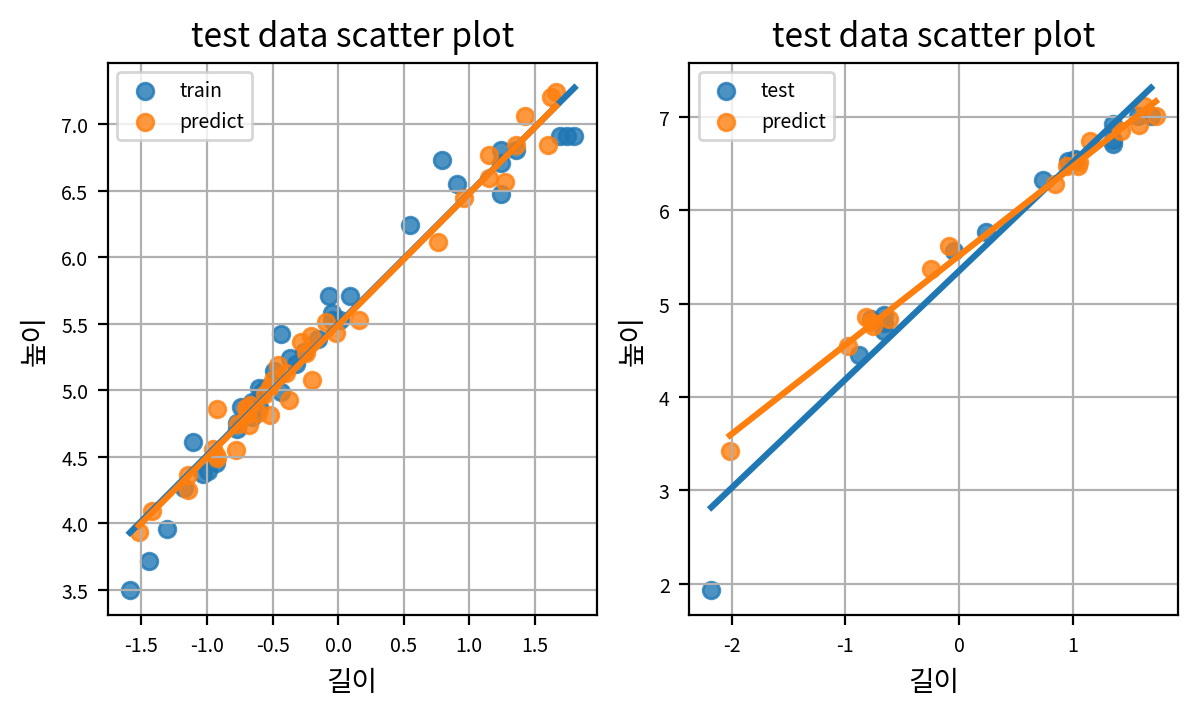

In [18]:
y1 = estimator.predict(x_train)
y2 = estimator.predict(x_test)

width_px = 1200
height_px = 720
rows = 1
cols = 2
figsize = (width_px/ my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# bar 그리기
sb.regplot(data=x_train,             
           x = '길이',            
           y =y_train,         
           ci = 0,              
           label ='train',
           ax=ax[0])        
sb.regplot(data=x_train,             
           x = '높이',            
           y =y1,         
           ci = 0,              
           label ='predict',
           ax=ax[0])
ax[0].set_title('test data scatter plot', fontsize = 12)
ax[0].set_xlabel('길이', fontsize = 10)
ax[0].set_ylabel('높이', fontsize = 10)
ax[0].legend()    
ax[0].grid(True)

sb.regplot(data=x_test,             
           x = '길이',            
           y =y_test,         
           ci = 0,              
           label ='test',
           ax=ax[1])        
sb.regplot(data=x_test,             
           x = '높이',            
           y =y2,         
           ci = 0,              
           label ='predict',
           ax=ax[1])
ax[1].set_title('test data scatter plot', fontsize = 12)
ax[1].set_xlabel('길이', fontsize = 10)
ax[1].set_ylabel('높이', fontsize = 10)
ax[1].legend()    
ax[1].grid(True)
# 출력
plt.tight_layout()
plt.show()
plt.close()

## 5. 예측
### 1. 가상 데이터 생성후 예측값 만들기

In [19]:
# 농어의 길이, 높이, 두께에 대한 가상 데이터 생성
new_data = DataFrame(
    {
        '길이': [5.0, 7.0, 5.0],
        '높이': [6.0, 3.0, 3.0],
        '두께': [3.5, 4.0, 2.5]
    }
)

# 스케일링이 적용된 변수에는 동일한 스케일링 적용 필요
# fit_transfrom 아님에 주의
std_new_data = DataFrame(scaler.transform(new_data), columns = new_data.columns)

# 가상 데이터에 대한 무게 예측
predicted_log_weight = estimator.predict(std_new_data)
predicted_weight = np.expm1(predicted_log_weight)

# 소수점 셋째자리까지 반올림하여 저장
new_data['예측된 무게'] = predicted_weight
new_data

,길이,높이,두께,예측된 무게
0,5.0,6.0,3.5,39.491499
1,7.0,3.0,4.0,39.090617
2,5.0,3.0,2.5,28.458434
